# Using a Qubit specifier

This tutorial shows you how to ...

In [1]:
%load_ext autoreload
%autoreload 2

## Compute circuit output probabilities with `POVMSampler`
Follow these instructions to get the probability distribution of a quantum circuit with the `povm_toolbox.sampler.POVMSampler` sampler.

### Initialize QuantumCircuit
The first step is to create the `qiskit.circuit.QuantumCircuits` from which you want to obtain the probability distribution.

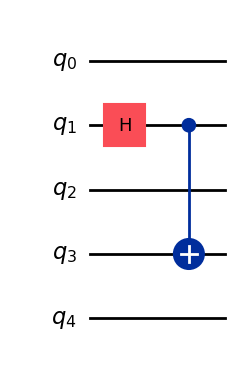

In [2]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(5)
qc.h(1)
qc.cx(1, 3)
qc.draw("mpl", style="iqp")

> **Note**: 
>
> The `qiskit.circuit.QuantumCircuit` you pass to `povm_toolbox.sampler.POVMSampler` must not include measurements. These will later be specified by the chosen POVM.

### Initialize `Sampler` and `POVMSampler`
Next, create a `povm_toolbox.sampler.POVMSampler` instance, which will internally use a `qiskit.primitives.Sampler` instance.

In [3]:
from povm_toolbox.sampler import POVMSampler
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()
povm_sampler = POVMSampler(sampler=sampler)

### Initialize measurement procedure
Next, create a `povm_toolbox.library.POVMImplementation` instance.

In [4]:
from povm_toolbox.library import ClassicalShadows

measurement = ClassicalShadows(n_qubit=2, qubit_specifier=[1, 3])

### Run and get results
Now that you have defined your `povm_sampler`, run it by calling the `povm_toolbox.sampler.POVMSampler.run` method, which returns an instance of `povm_toolbox.sampler.POVMSamplerJob`. You can get the results from the job (as a `qiskit.primitives.PrimitiveResult` object) with the `povm_toolbox.sampler.POVMSamplerJob.result` method.

In [5]:
job = povm_sampler.run([qc], shots=256, povm=measurement)
result = job.result()
print(result)

PrimitiveResult([POVMPubResult(data=DataBin<>(povm_measurement_creg=BitArray(<shape=(), num_shots=256, num_bits=2>)), metadata=RPMMetadata(povm_implementation=ClassicalShadows(n_qubits=2), composed_circuit=<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x13f534170>, pvm_keys=np.ndarray<256,2>))], metadata={'raw_results': PrimitiveResult([PubResult(data=DataBin<256>(povm_measurement_creg=BitArray(<shape=(256,), num_shots=1, num_bits=2>)), metadata={'shots': 1})], metadata={})})


While this example only uses one `qiskit.circuit.QuantumCircuit`, you can sample multiple circuits by passing a list of `povm_toolbox.sampler.POVMSamplerPubLike` objects to the `povm_toolbox.sampler.POVMSampler.run` method.

For each supplied `POVMSamplerPub`, the resulting `PrimitiveResult` object stores a corresponding `povm_toolbox.sampler.POVMPubResult` object.

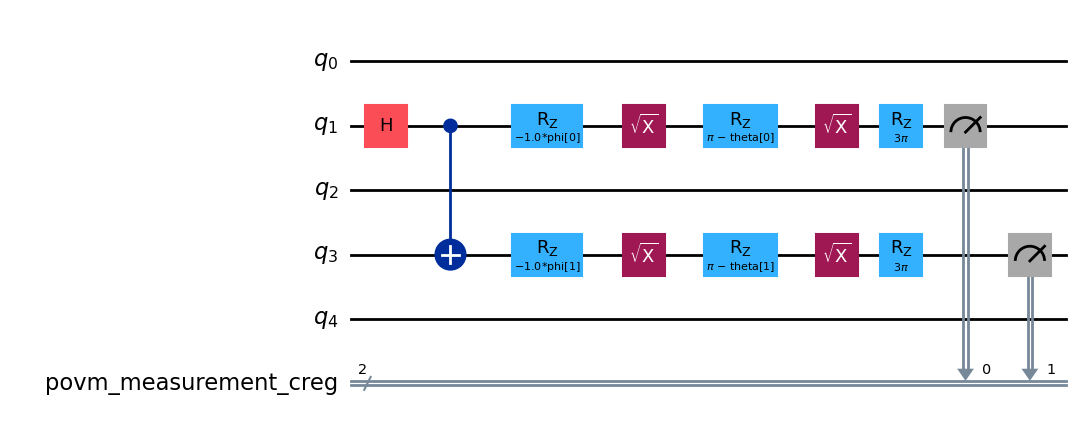

In [6]:
result[0].metadata.composed_circuit.draw("mpl")

In [7]:
print(result[0].metadata.povm_implementation.definition())

ProductPOVM(n_subsystems=2)<6,6>:
   (1,): SingleQubitPOVM<6> at 0x144359220
   (3,): SingleQubitPOVM<6> at 0x143510a70


### Get the outcome counts

From these results you can extract the outcome counts with the method `povm_toolbox.sampler.POVMSPubResult.get_counts`.

In [8]:
pub_result = result[0]
counts = pub_result.get_counts()
print(counts)

[Counter({(5, 4): 21, (4, 5): 19, (1, 1): 18, (0, 0): 17, (5, 2): 13, (2, 2): 12, (3, 3): 11, (1, 5): 11, (1, 2): 10, (3, 1): 10, (0, 2): 9, (5, 0): 9, (2, 1): 8, (0, 4): 8, (2, 4): 8, (4, 0): 8, (0, 3): 7, (3, 0): 7, (2, 5): 6, (4, 3): 6, (4, 1): 5, (0, 5): 5, (2, 0): 5, (3, 5): 5, (4, 2): 4, (3, 4): 4, (5, 3): 4, (1, 4): 2, (1, 3): 2, (5, 1): 2})]


## Compute an expectation value with the `POVMPostProcessor`

After having sampled some POVM outcomes, follow these instructions to get the expected value of an observable for a given quantum circuit with the `povm_toolbox.post_processor.POVMPostProcessor`.


### Initialize observables
The first step is to define the observables whose expected value you want to compute. Each observable can be any `BaseOperator`, like the operators from `qiskit.quantum_info`. Among them it is preferable to use `qiskit.quantum_info.SparsePauliOp`.

In [9]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])

### Initialize the `POVMPostProcessor`

A `POVMPostProcessor` is initialized with an instance of a `POVMPubResult`.

In [10]:
from povm_toolbox.post_processor import POVMPostProcessor

post_processor = POVMPostProcessor(pub_result)

### Get the expected value

One can request the expectation value of an observable with the method `povm_toolbox.post_processor.POVMPostProcessor.get_expectation_value`.

In [11]:
# TODO

# exp_value = post_processor.get_expectation_value(observable)
# print(exp_value)

IndexError: string index out of range

For reference, we can compare our estimated expectation value to the exact value.

The post-processor can also compute the (estimated) standard deviation of the estimator we built.


In [ ]:
# TODO

# import numpy as np
# from qiskit.quantum_info import Statevector

# exact_expectation_value = np.real_if_close(Statevector(qc).expectation_value(observable))
# print(f"Exact value:     {exact_expectation_value}")

# exp_value, std = post_processor.get_single_exp_value_and_std(observable)
# print(f"Estimated value: {exp_value}")
# print(f"\nEstimated standard deviation of the estimator: {std}")